# **TECNICATURA UNIVERSITARIA EN INTELIGENCIA ARTIFICIAL**  
## TRABAJO PRÁCTICO N° 3: MINERÍA DE DATOS  
### **INTEGRANTES:** Caballero, Franco - (C-7328/8) | Rosito, Valentin - (R-4662/1)
### **Fecha Límite de Entrega:** 6/06/2025  
### **Semestre:** 1° Semestre 2025


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay 
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import plot_tree

# Ejercicio 1: EDA 

**VARIABLES**  

Temperatura → Temperatura diaria registrada (en grados Celsius).  
Humedad → Porcentaje de humedad relativa en el ambiente.  
VientoVelocidad → Velocidad del viento (en km/h).  
Precipitation → Precipitación diaria acumulada (en mm).  
PresionAtmosferica → Presión atmosférica medida (en hPa).  
Localizacion → Ubicación geográfica donde se tomaron las mediciones (Llanura, Montaña, Costa).  
TipoClima → Clasificación climática general del día (Soleado, Lluvioso, Nublado, Nevado).  

**TARGET**
  
Estacion → Estación del año (primavera, verano, otoño, invierno). 

In [37]:
df = pd.read_csv('dxWeather.csv')

In [38]:
# Observamos de que tipo es cada columna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10090 entries, 0 to 10089
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Temperatura         10090 non-null  int64  
 1   Humedad             10090 non-null  int64  
 2   VientoVelocidad     10090 non-null  float64
 3   Precipitation       10090 non-null  int64  
 4   PresionAtmosferica  10090 non-null  float64
 5   Localizacion        10090 non-null  object 
 6   TipoClima           10090 non-null  object 
 7   Estacion            10090 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 630.8+ KB


In [39]:
# Podemos observar que no hay columnas duplicadas
df.duplicated().sum()

0

In [40]:
# Podemos ver que no hay valores nulos
df.isnull().sum()

Temperatura           0
Humedad               0
VientoVelocidad       0
Precipitation         0
PresionAtmosferica    0
Localizacion          0
TipoClima             0
Estacion              0
dtype: int64

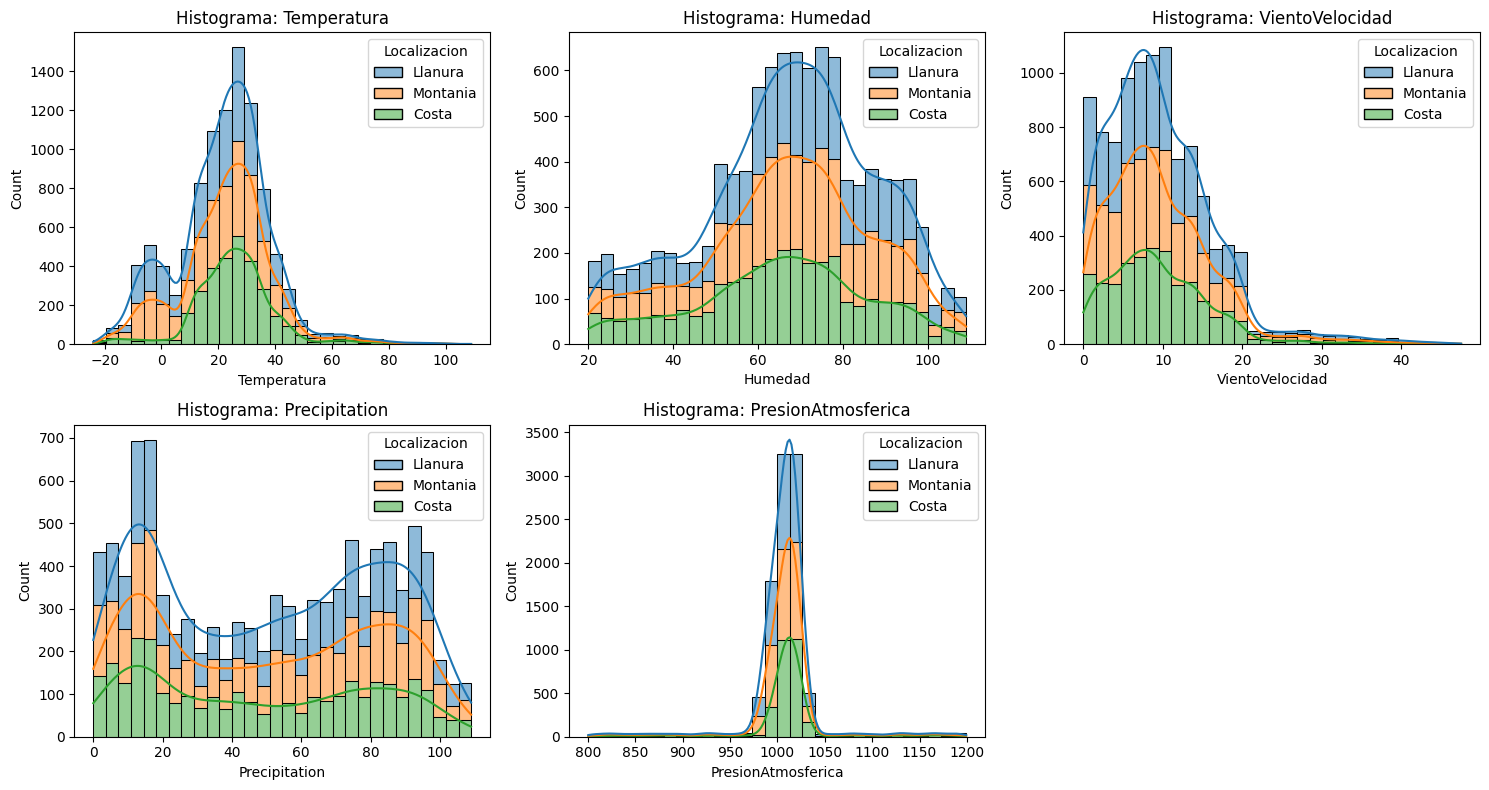

In [41]:
# Hacemos histogramas de las variables numéricas
variables_numericas = ['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation', 'PresionAtmosferica']

plt.figure(figsize=(15, 8))
for i, columna in enumerate(variables_numericas):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df, x=columna, kde=True, bins=30, color='skyblue', hue='Localizacion', multiple='stack')
    plt.title(f'Histograma: {columna}')
plt.tight_layout()
plt.show()

Se puede observar que:     

**Temperatura** → Distribución aproximadamente normal, ligeramente sesgada hacia la derecha. La mayoría de los valores se concentran entre 20 y 30 °C, con algunos valores extremos más altos.  

**Humedad** → Distribución casi normal, centrada en torno al 70–80 %. Es simétrica y refleja una variabilidad típica de esta variable.

**VientoVelocidad** → Distribución asimétrica positiva. Predominan los valores bajos (0–10 km/h), mientras que los vientos fuertes son poco frecuentes.  

**Precipitation** → Distribución bimodal y no simétrica. Presenta dos picos claros, lo que sugiere diferentes patrones de lluvia, posiblemente estacionales.  

**PresionAtmosferica** → Distribución normal muy concentrada alrededor de 1010 hPa. Tiene poca dispersión y unos pocos valores atípicos en los extremos.

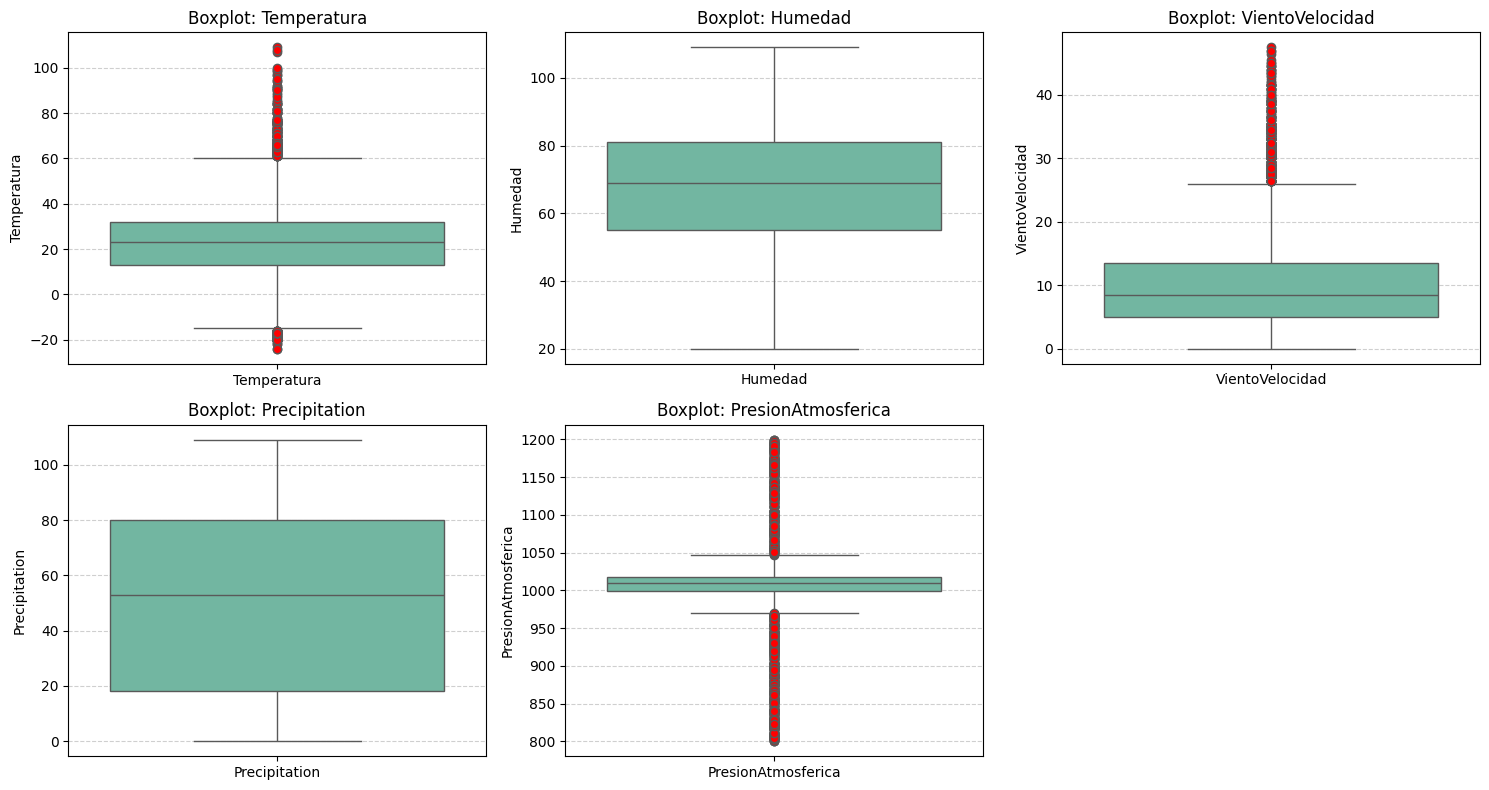

In [42]:
# Crear los subplots
plt.figure(figsize=(15, 8))

for i, columna in enumerate(variables_numericas):
    plt.subplot(2, 3, i + 1)
    
    # Creamos un DataFrame temporal con una columna dummy para evitar el warning
    temp_df = df[[columna]].copy()
    temp_df['Variable'] = columna  # Columna constante, solo para usar como hue
    
    sns.boxplot(
        data=temp_df,
        x='Variable',
        y=columna,
        hue='Variable',
        palette='Set2',
        legend=False,
        flierprops=dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none')
    )
    
    plt.title(f'Boxplot: {columna}')
    plt.xlabel('')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Podemos observar que hay outliers en PresionAtmosferica, Temperatura y VientoVelocidad

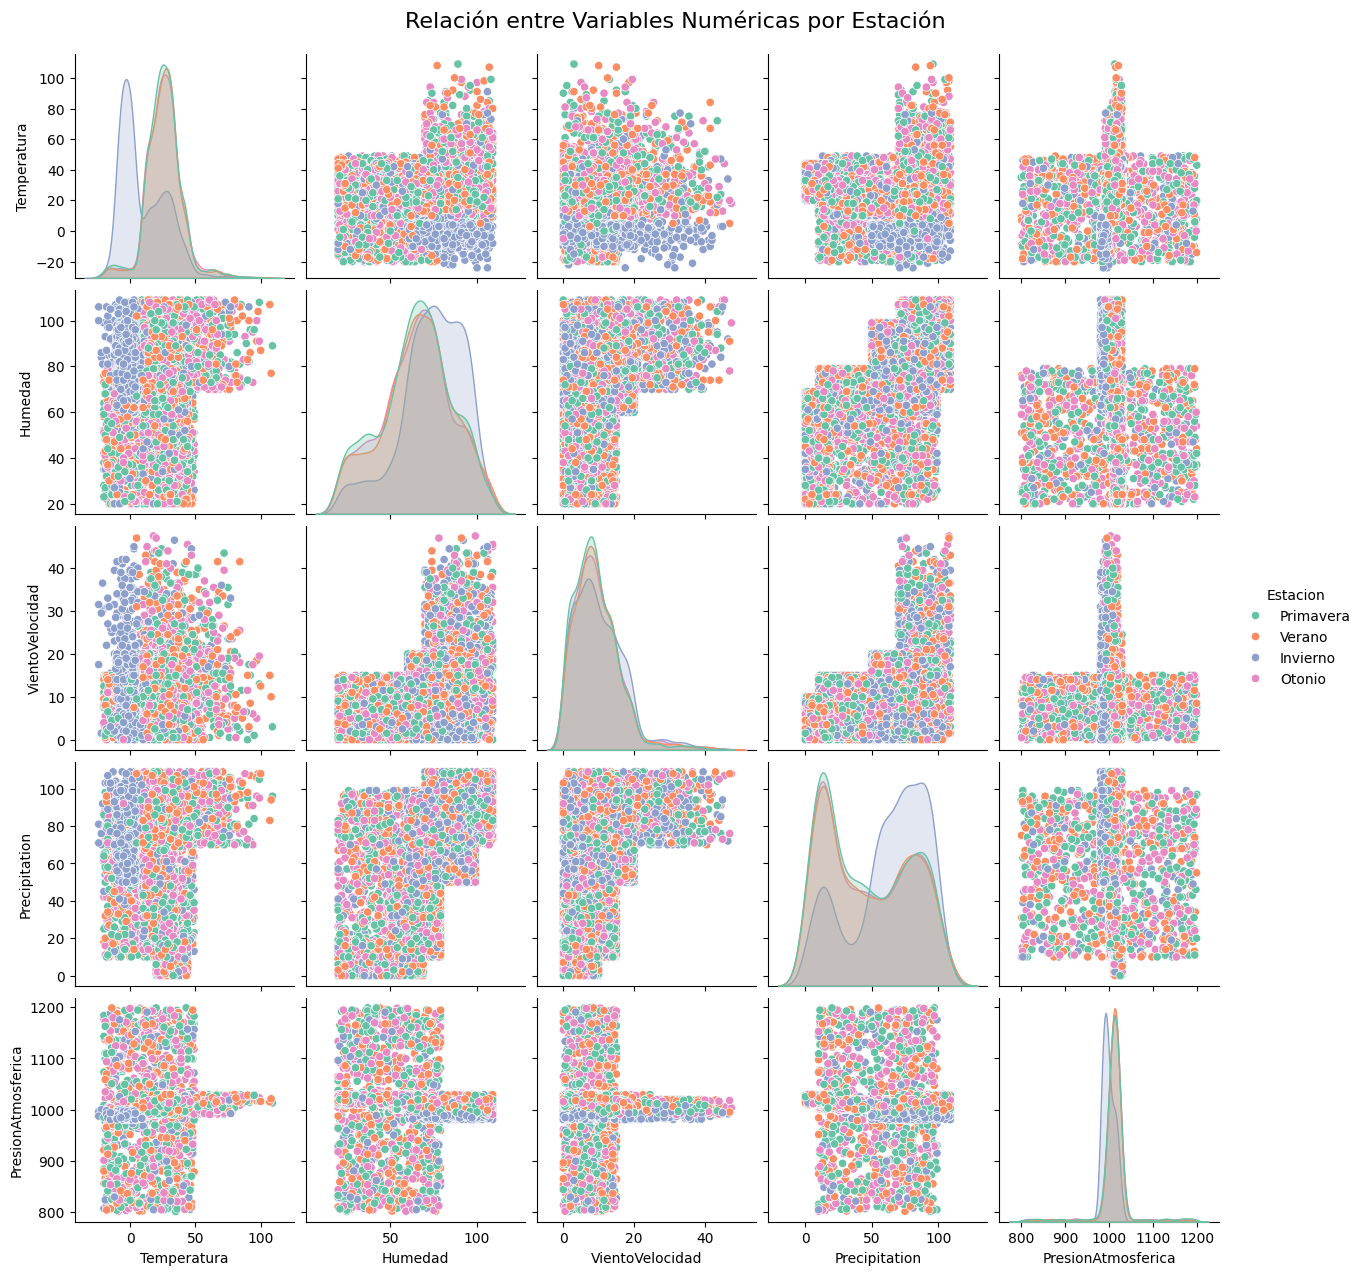

In [43]:
# Pairplot coloreado por Estación
sns.pairplot(df, vars=variables_numericas, hue="Estacion", palette="Set2", diag_kind="kde")
plt.suptitle("Relación entre Variables Numéricas por Estación", y=1.02, fontsize=16)
plt.show()

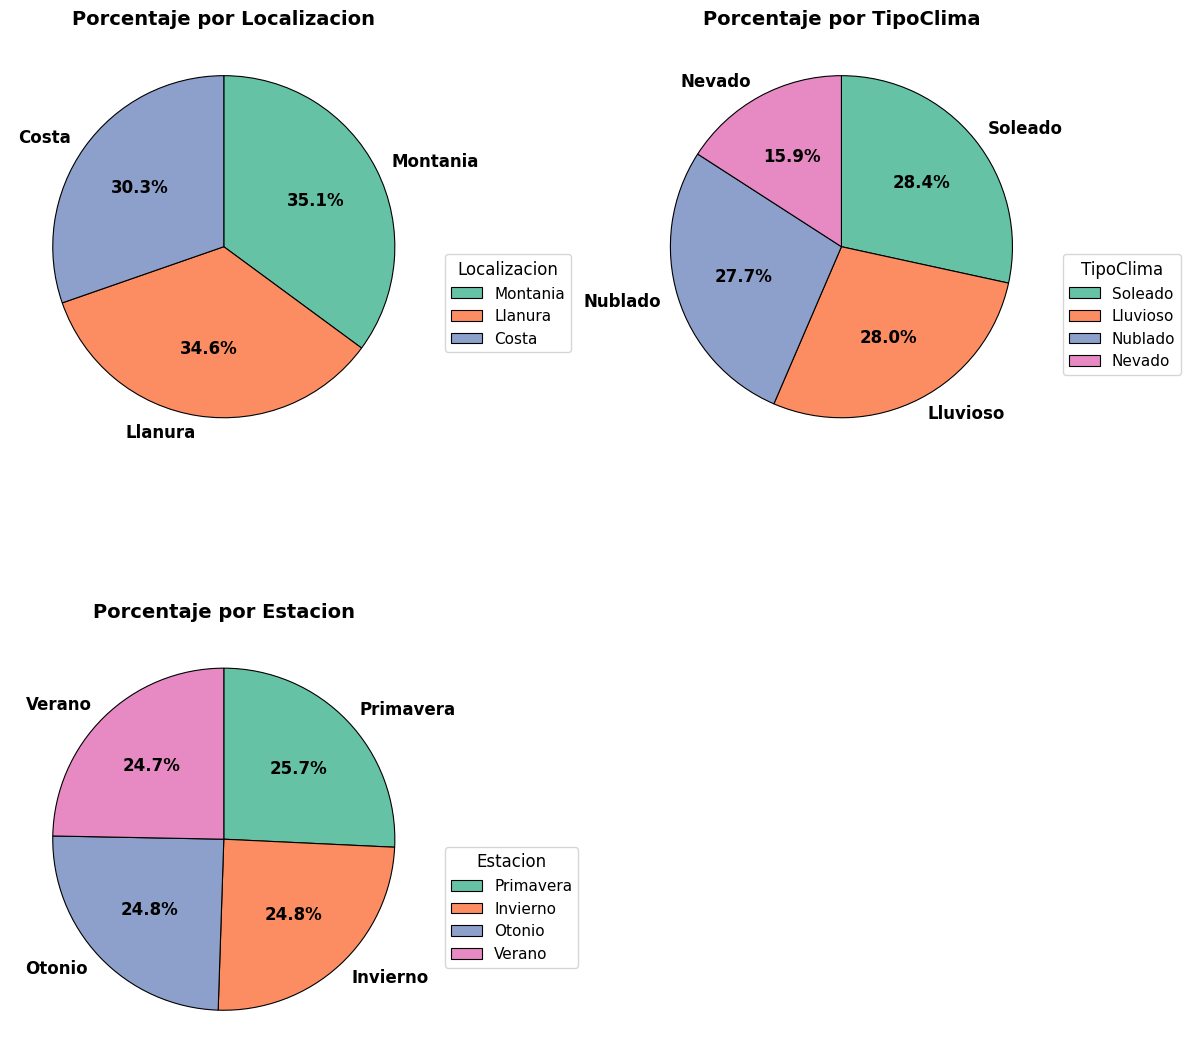

In [67]:
# Lista de variables categóricas
variables_categoricas = ['Localizacion', 'TipoClima', 'Estacion']

palette = 'Set1'

fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(2, 2)

axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0])
]

for ax, col in zip(axes, variables_categoricas):
    df[col].value_counts().plot.pie(
        ax=ax,
        autopct=lambda pct: f'{pct:.1f}%',
        startangle=90,
        counterclock=False,
        colors=sns.color_palette('Set2', n_colors=df[col].nunique()),
        textprops={'weight': 'bold', 'fontsize': 12},
        wedgeprops={'edgecolor': 'black', 'linewidth': 0.8}
    )
    ax.set_ylabel('')
    ax.set_title(f'Porcentaje por {col}', fontsize=14, fontweight='bold')
    ax.legend(
        loc='best',
        bbox_to_anchor=(1, 0.5),
        title=f'{col}',
        title_fontsize=12,
        fontsize=11
    )

fig.delaxes(fig.add_subplot(gs[1, 1]))

plt.tight_layout()
plt.show()


Se puede ver que la variable target está balanceada

### Outliers

Dejar Outliers PresionAtmosferica, los de viento se explican por Precipitacion y Humedad, eliminar Outliers Temperatura mayores a 60

In [45]:
# Creamos una copia del DataFrame para filtrar outliers
df_filtrado = df.copy()

# Contador total de filas antes de eliminar outliers
total_filas = df_filtrado.shape[0]

# Eliminamos valores atípicos de Temperatura > 60°C (según boxplot)
df_filtrado = df_filtrado[df_filtrado['Temperatura'] <= 60]

# Eliminamos valores atípicos de VientoVelocidad > 30 km/h
df_filtrado = df_filtrado[df_filtrado['VientoVelocidad'] <= 30]

# Eliminamos los valores de humedad que son mayores a 100%
df_filtrado = df_filtrado[df_filtrado['Humedad'] <= 100]

# Los registros de PresiónAtmosférica se mantienen sin cambios, ya que no se identifican outliers
# (no hay filtrado necesario para esta columna)

# Mostrar porcentaje de filas eliminadas por outliers en Temperatura y VientoVelocidad
filas_eliminadas = total_filas - df_filtrado.shape[0]
porcentaje_eliminado = (filas_eliminadas / total_filas) * 100
print(f"Se eliminaron {filas_eliminadas} filas ({porcentaje_eliminado:.2f}%) por outliers")

# Mostrar filas restantes después de eliminar outliers
print(f"Filas restantes después de eliminar outliers: {df_filtrado.shape[0]}")

Se eliminaron 592 filas (5.87%) por outliers
Filas restantes después de eliminar outliers: 9498


In [46]:
df_filtrado.describe()

,Temperatura,Humedad,VientoVelocidad,Precipitation,PresionAtmosferica
count,9498.000000,9498.000000,9498.000000,9498.000000,9498.000000
mean,20.798694,65.425774,8.944041,48.397347,1007.630302
std,14.744152,19.556163,5.600743,31.692183,39.843725
min,-24.000000,20.000000,0.000000,0.000000,800.230000
25%,13.000000,53.000000,4.500000,17.000000,998.542500
50%,23.000000,67.000000,8.500000,49.000000,1010.285000
75%,31.000000,79.000000,13.000000,77.000000,1017.820000
max,60.000000,100.000000,30.000000,109.000000,1199.210000


Eliminamos exclusivamente los valores atípicos de **Temperatura superiores a 60 °C**, dado que el rango posible oscila entre −24 °C y 60 °C.  

En **VientoVelocidad**, descartamos únicamente las mediciones que exceden 30 km/h, ya que el resto de los valores extremos son posibles y están justificados por la Precipitación y la Humedad (Dados por correlaciones positivas de 042 y 0.48 respectivamente).  

Los registros de **PresiónAtmosférica** se mantienen, pues todos los valores observados se encuentran dentro de rangos válidos.

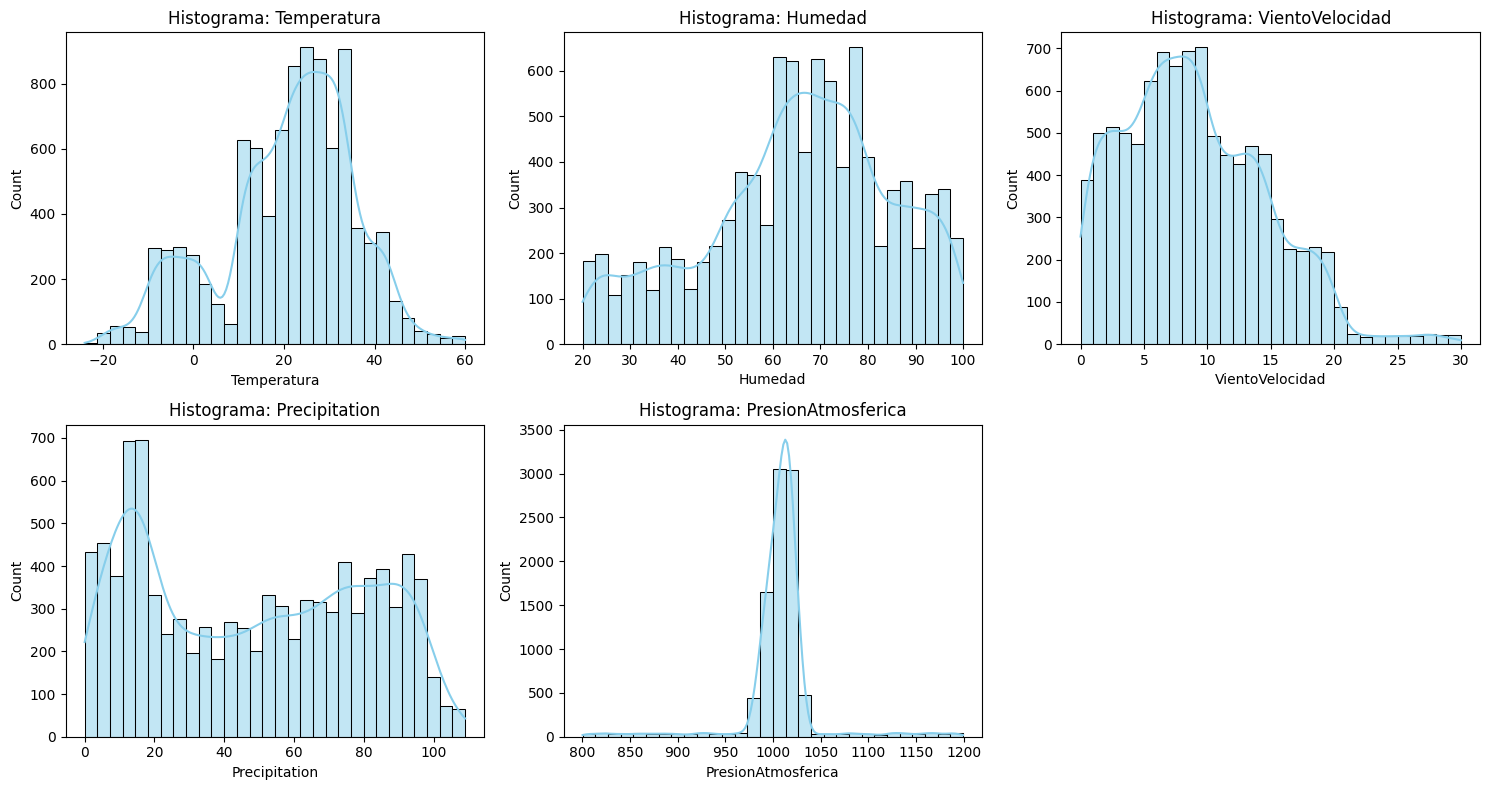

In [47]:
# Vemos como se ven los histogramas de las variables numéricas después de eliminar outliers
plt.figure(figsize=(15, 8))
for i, columna in enumerate(variables_numericas):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df_filtrado, x=columna, kde=True, bins=30, color='skyblue')
    plt.title(f'Histograma: {columna}')
plt.tight_layout()
plt.show()

Se puede observar que, tras eliminar los outliers, las distribuciones se vuelven más limpias y representativas del comportamiento central de los datos.  
La variable Temperatura ahora muestra una forma bimodal, sin estar sesgada hacia la derecha. Por otra parte, en VientoVelocidad se redujo notablemente la asimetría y dispersión, eliminando colas largas y picos extremos. Humedad, Precipitation y PresionAtmosferica, mantuvieron su forma general. En conjunto, las distribuciones se ven más suaves y centradas, facilitando el análisis.

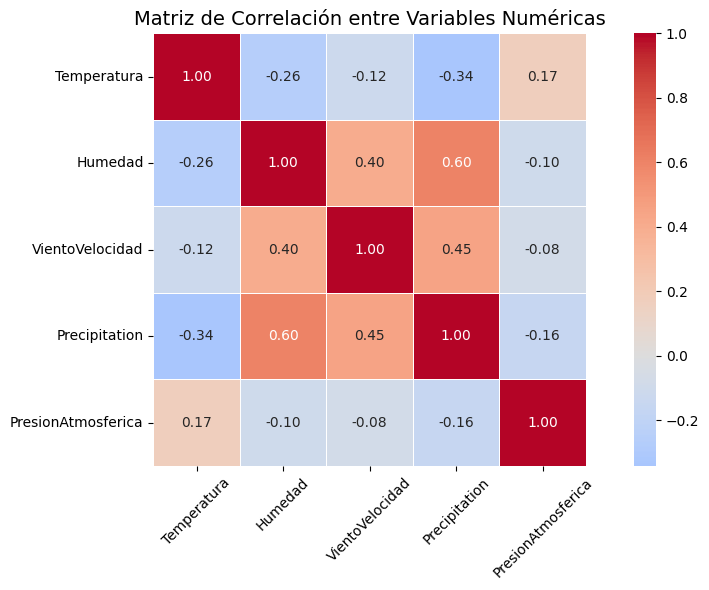

In [48]:
# Calculamos la matriz de correlación
matriz_correlacion = df_filtrado[variables_numericas].corr()

# Visualizamos con un heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', center=0,
            linewidths=0.5, fmt=".2f", square=True)

plt.title("Matriz de Correlación entre Variables Numéricas", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Podemos ver que la correlacion mas fuerte es positiva y se da entre Precipitacion y Humedad 

### Partición

In [49]:
# Definimos las features relevantes y la variable target
features = [
    'Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation', 'PresionAtmosferica',
    'Localizacion', 'TipoClima'
]
target = 'Estacion'

# Separamos en conjuntos de entrenamiento y prueba usando únicamente las features definidas (80-20)
X_train, X_test, y_train, y_test = train_test_split(df_filtrado[features], df_filtrado[target], test_size=0.2, random_state=42)


## Ejercicio 2
-------

### Pipeline (Codificación de variables categóricas y escalado de variables continuas)

In [50]:
# Preprocesamiento: OHE para categóricas y escalado para numéricas
preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), variables_numericas),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Localizacion', 'TipoClima'])
])

# Pipeline con SVM lineal
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('svc', SVC(kernel='linear', random_state=42))
])
param_grid = {
    'svc__C': [0.0001, 0.001,  0.01, 1, 10]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

# Entrenamos el modelo con el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# Mostramos el mejor valor de 'C' encontrado
print("Best params:", grid_search.best_params_)

# Reemplazamos el pipeline por el mejor estimador
pipeline = grid_search.best_estimator_

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred  = pipeline.predict(X_test)

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.3f}")
print(f"Train Precision: {precision_score(y_train, y_train_pred, average='macro'):.3f}")
print(f"Train Recall: {recall_score(y_train, y_train_pred, average='macro'):.3f}")
print(f"Train F1 Score: {f1_score(y_train, y_train_pred, average='macro'):.3f}")
print("--------------------")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.3f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred, average='macro'):.3f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred, average='macro'):.3f}")
print(f"Test F1 Score: {f1_score(y_test, y_test_pred, average='macro'):.3f}")


Best params: {'svc__C': 1}
Train Accuracy: 0.387
Train Precision: 0.289
Train Recall: 0.378
Train F1 Score: 0.280
--------------------
Test Accuracy: 0.388
Test Precision: 0.289
Test Recall: 0.388
Test F1 Score: 0.288


/Users/valentinrosito/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/valentinrosito/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [51]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(
    pipeline,
    X_test,
    y_test,
    cv=skf,
    scoring=['accuracy', 'f1_macro', 'precision_macro'],
    return_estimator=False
)

# Creamos un DataFrame con los resultados de cada fold
df_cv = pd.DataFrame({
    'Fold': np.arange(1, 6),
    'Accuracy': scores['test_accuracy'],
    'Precision': scores['test_precision_macro'],
    'F1': scores['test_f1_macro']
})
print(f"Promedio de Accuracy: {df_cv['Accuracy'].mean():.3f}")
print(f"Promedio de Precision: {df_cv['Precision'].mean():.3f}")
print(f"Promedio de F1: {df_cv['F1'].mean():.3f}")
df_cv

Promedio de Accuracy: 0.394
Promedio de Precision: 0.444
Promedio de F1: 0.403


,Fold,Accuracy,Precision,F1
0,1,0.421053,0.468371,0.439954
1,2,0.386842,0.435260,0.375622
2,3,0.415789,0.465748,0.432958
3,4,0.350000,0.413621,0.348207
4,5,0.397368,0.437844,0.415827


Las mejores métricas de SVC se consiguieron al **escalar las variables continuas con MinMaxScaler** y ajustar el hiperparámetro **C a 0.001**. 

Este valor de C implica **una regularización fuerte**, penalizando más los errores de clasificación para maximizar el margen y evitar el sobreajuste, a costa de tolerar más fallos en el entrenamiento.  

El rendimiento limitado también puede explicarse por el uso de un kernel lineal, que, al ser más sencillo, no logra modelar relaciones no lineales complejas en los datos.

## Ejercicio 3 - Uso de Kernel Gaussiano
--------

In [52]:
pipeline_gauss = Pipeline([
    ('preproc', preprocessor),
    ('svc', SVC(kernel='rbf', random_state=42))
])
param_grid = {
    'svc__C': [0.0001, 0.001, 0.01, 1, 10],
    'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1]
}

grid_search_g = GridSearchCV(
    pipeline_gauss,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

grid_search_g.fit(X_train, y_train)

print("Best params:", grid_search_g.best_params_)

# Reemplazamos el pipeline por el mejor estimador
pipeline_gauss = grid_search_g.best_estimator_

pipeline_gauss.fit(X_train, y_train)

y_train_pred = pipeline_gauss.predict(X_train)
y_test_pred  = pipeline_gauss.predict(X_test)

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.3f}")
print(f"Train Precision: {precision_score(y_train, y_train_pred, average='macro'):.3f}")
print(f"Train Recall: {recall_score(y_train, y_train_pred, average='macro'):.3f}")
print(f"Train F1 Score: {f1_score(y_train, y_train_pred, average='macro'):.3f}")
print("--------------------")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.3f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred, average='macro'):.3f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred, average='macro'):.3f}")
print(f"Test F1 Score: {f1_score(y_test, y_test_pred, average='macro'):.3f}")

Best params: {'svc__C': 10, 'svc__gamma': 1}
Train Accuracy: 0.450
Train Precision: 0.517
Train Recall: 0.448
Train F1 Score: 0.462
--------------------
Test Accuracy: 0.389
Test Precision: 0.460
Test Recall: 0.393
Test F1 Score: 0.407


In [53]:
scores = cross_validate(
    pipeline_gauss,
    X_test,
    y_test,
    cv=skf,
    scoring=['accuracy', 'f1_macro', 'precision_macro'],
    return_estimator=False
)

# Creamos un DataFrame con los resultados de cada fold
df_cv = pd.DataFrame({
    'Fold': np.arange(1, 6),
    'Accuracy': scores['test_accuracy'],
    'Precision': scores['test_precision_macro'],
    'F1': scores['test_f1_macro']
})
print(f"Promedio de Accuracy: {df_cv['Accuracy'].mean():.3f}")
print(f"Promedio de Precision: {df_cv['Precision'].mean():.3f}")
print(f"Promedio de F1: {df_cv['F1'].mean():.3f}")
df_cv

Promedio de Accuracy: 0.394
Promedio de Precision: 0.462
Promedio de F1: 0.416


,Fold,Accuracy,Precision,F1
0,1,0.392105,0.458500,0.416796
1,2,0.415789,0.477519,0.434921
2,3,0.376316,0.441618,0.399576
3,4,0.352632,0.448809,0.377640
4,5,0.431579,0.483149,0.451167


Las mejores métricas del SVC con kernel gaussiano (RBF) se lograron al escalar las variables continuas con MinMaxScaler y ajustar los hiperparámetros C a 10 y gamma a 0.01.

El modelo mostró un ajuste adecuado en entrenamiento, pero el desempeño en prueba es limitado y muy similar al del SVC lineal.

Esto indica que, aunque el kernel RBF puede modelar relaciones no lineales, en este caso los datos o las características disponibles no permiten una mejora significativa en el rendimiento.

Podría ser necesario explorar otras técnicas o realizar más ingeniería de características para lograr mejores resultados.

## Ejercicio 4 - Uso de Random Forest
-------

In [54]:
# Pipeline con Random Forest
pipeline_rf = Pipeline([
    ('preproc', preprocessor),
    ('rf', RandomForestClassifier(random_state=42))
])

# Búsqueda de hiperparámetros
param_grid_rf = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 3, 5, 7, 10, 13, 15]
}

grid_search_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

# Entrenamiento
grid_search_rf.fit(X_train, y_train)

# Mejor combinación de parámetros
print("Mejores parámetros (Random Forest):", grid_search_rf.best_params_)

# Predicción
best_rf = grid_search_rf.best_estimator_
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Métricas 
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.3f}")
print(f"Train Precision: {precision_score(y_train, y_train_pred, average='macro'):.3f}")
print(f"Train Recall: {recall_score(y_train, y_train_pred, average='macro'):.3f}")
print(f"Train F1 Score: {f1_score(y_train, y_train_pred, average='macro'):.3f}")
print("--------------------")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.3f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred, average='macro'):.3f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred, average='macro'):.3f}")
print(f"Test F1 Score: {f1_score(y_test, y_test_pred, average='macro'):.3f}")

Mejores parámetros (Random Forest): {'rf__max_depth': 10, 'rf__n_estimators': 100}
Train Accuracy: 0.737
Train Precision: 0.777
Train Recall: 0.736
Train F1 Score: 0.739
--------------------
Test Accuracy: 0.399
Test Precision: 0.477
Test Recall: 0.403
Test F1 Score: 0.421


In [55]:
# Usamos el mejor pipeline de Random Forest para validación cruzada
scores = cross_validate(
    best_rf,
    X_test,
    y_test,
    cv=skf,
    scoring=['accuracy', 'f1_macro', 'precision_macro'],
    return_estimator=False
)

# Creamos un DataFrame con los resultados de cada fold
df_cv = pd.DataFrame({
    'Fold': np.arange(1, 6),
    'Accuracy': scores['test_accuracy'],
    'Precision': scores['test_precision_macro'],
    'F1': scores['test_f1_macro']
})
print(f"Promedio de Accuracy: {df_cv['Accuracy'].mean():.3f}")
print(f"Promedio de Precision: {df_cv['Precision'].mean():.3f}")
print(f"Promedio de F1: {df_cv['F1'].mean():.3f}")
df_cv

Promedio de Accuracy: 0.390
Promedio de Precision: 0.464
Promedio de F1: 0.414


,Fold,Accuracy,Precision,F1
0,1,0.428947,0.495384,0.452839
1,2,0.376316,0.450242,0.401195
2,3,0.386842,0.450680,0.408915
3,4,0.302632,0.411256,0.333345
4,5,0.455263,0.511032,0.475198


Las mejores métricas del Random Forest se obtuvieron al ajustar los hiperparámetros a max_depth = 10 y n_estimators = 50.

El modelo muestra un buen desempeño en entrenamiento, con precisión y recall alrededor del 70%. Sin embargo, en el conjunto de prueba, la precisión baja significativamente a 0.389, lo que indica que el modelo tiene dificultades para generalizar correctamente a datos nuevos.

Esta diferencia entre entrenamiento y prueba sugiere la presencia de sobreajuste o la alta complejidad y ruido en los datos, limitando la capacidad del modelo para predecir con precisión fuera del conjunto de entrenamiento.

Para mejorar el desempeño, se podría considerar aumentar la cantidad de datos, realizar una mejor selección de variables o aplicar técnicas que reduzcan el sobreajuste.


### Visualizacion Random Forest

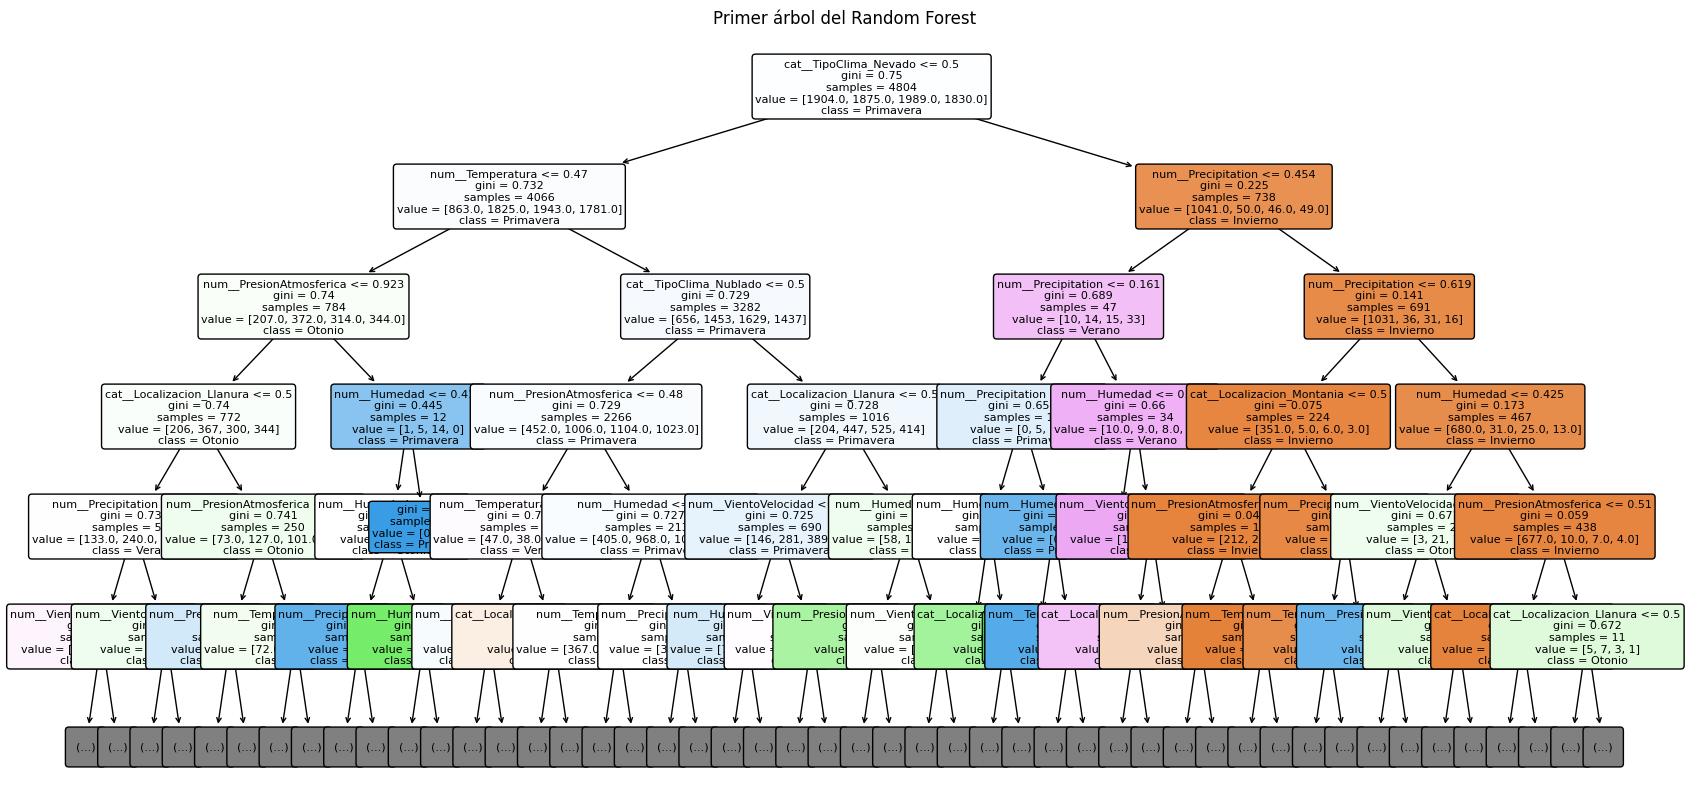

In [56]:
# Aplicar preprocesamiento a X_train 
preprocessor.fit(X_train)

# Extraer el Random Forest del pipeline con los mejores parámetros
rf_model = best_rf.named_steps['rf']

# Visualizamos el primer árbol
plt.figure(figsize=(20, 10))
plot_tree(rf_model.estimators_[0], 
          filled=True, 
          feature_names=preprocessor.get_feature_names_out(), 
          class_names=rf_model.classes_,
          rounded=True,
          fontsize=8,
          max_depth=5)
plt.title("Primer árbol del Random Forest")
plt.show()

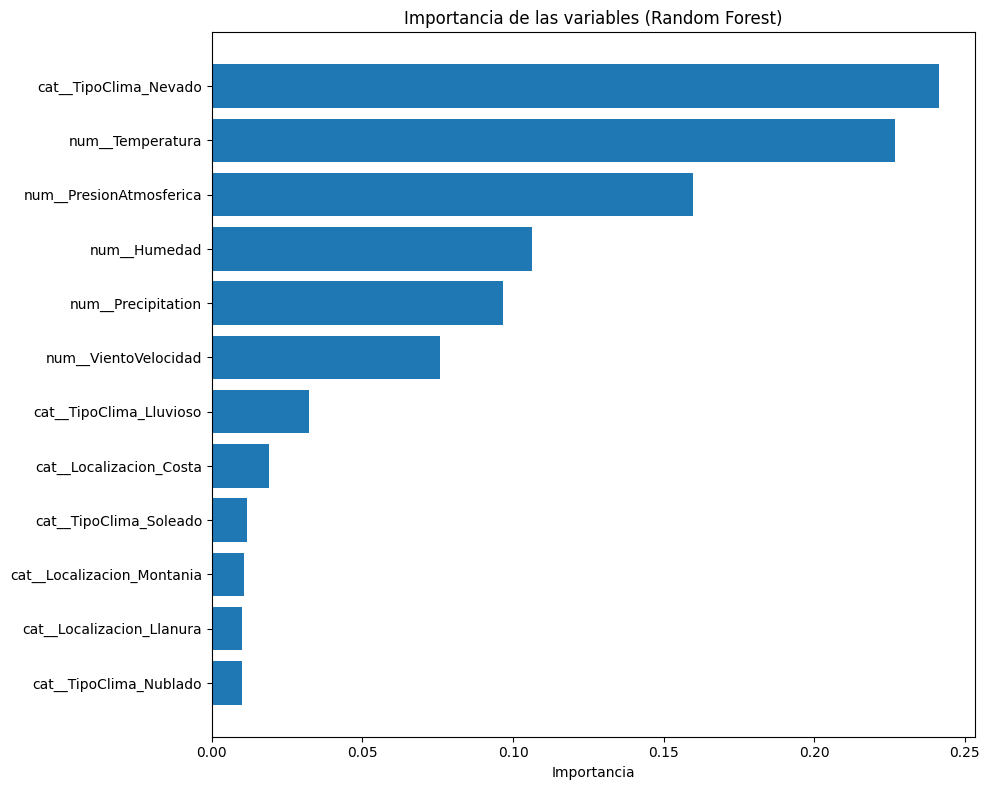

In [57]:
# Ajustamos el preprocesador con X_train para obtener los nombres transformados
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

# Extraemos el modelo Random Forest entrenado
rf_model = best_rf.named_steps['rf']

# Importancia de características
importances = rf_model.feature_importances_

# Ordenamos las importancias descendente
indices = np.argsort(importances)[::-1]

# Graficamos en horizontal
plt.figure(figsize=(10, 8))
plt.title("Importancia de las variables (Random Forest)")
plt.barh(range(len(importances)), importances[indices], align="center")
plt.yticks(range(len(importances)), feature_names[indices])
plt.xlabel("Importancia")
plt.gca().invert_yaxis()  # Para que las más importantes estén arriba
plt.tight_layout()
plt.show()


**TipoClima_Nevado** fue la variable más importante.  
Hipótesis: La nieve es característica del invierno, por lo que su presencia ayuda fuertemente a identificar esta estación.

**Temperatura** también fue muy relevante.  
Hipótesis: Cambia claramente entre estaciones, siendo baja en invierno y alta en verano, lo que la convierte en un buen indicador.

**Presión atmosférica** y **Humedad** tuvieron importancia también.  
Hipótesis: Aunque menos marcadas, sus variaciones estacionales ayudan al modelo.

**TipoClima_Nublado** fue la menos importante.  
Hipótesis: Puede aparecer en cualquier estación, por lo que no aporta mucha información para distinguirlas.

# Conclusiones


In [58]:
# Creamos el DataFrame de métricas
metrics_data = {
    'Modelo': ['SVM Lineal', 'SVM Gaussiano', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, pipeline.predict(X_test)),
        accuracy_score(y_test, pipeline_gauss.predict(X_test)),
        accuracy_score(y_test, best_rf.predict(X_test))
    ],
    'Precision': [
        precision_score(y_test, pipeline.predict(X_test), average='macro'),
        precision_score(y_test, pipeline_gauss.predict(X_test), average='macro'),
        precision_score(y_test, best_rf.predict(X_test), average='macro')
    ],
    'Recall': [
        recall_score(y_test, pipeline.predict(X_test), average='macro'),
        recall_score(y_test, pipeline_gauss.predict(X_test), average='macro'),
        recall_score(y_test, best_rf.predict(X_test), average='macro')
    ],
    'F1 Score': [
        f1_score(y_test, pipeline.predict(X_test), average='macro'),
        f1_score(y_test, pipeline_gauss.predict(X_test), average='macro'),
        f1_score(y_test, best_rf.predict(X_test), average='macro')
    ]
}

df_metrics = pd.DataFrame(metrics_data)
df_metrics

/Users/valentinrosito/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Modelo,Accuracy,Precision,Recall,F1 Score
0,SVM Lineal,0.387895,0.289239,0.387954,0.287966
1,SVM Gaussiano,0.389474,0.459769,0.392626,0.406547
2,Random Forest,0.399474,0.477062,0.402538,0.420573


/var/folders/l1/5h810w6x4hz_8yc4sfqwjlkr0000gn/T/ipykernel_11661/3608276083.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(modelos, rotation=15, fontsize=12, fontweight='bold')


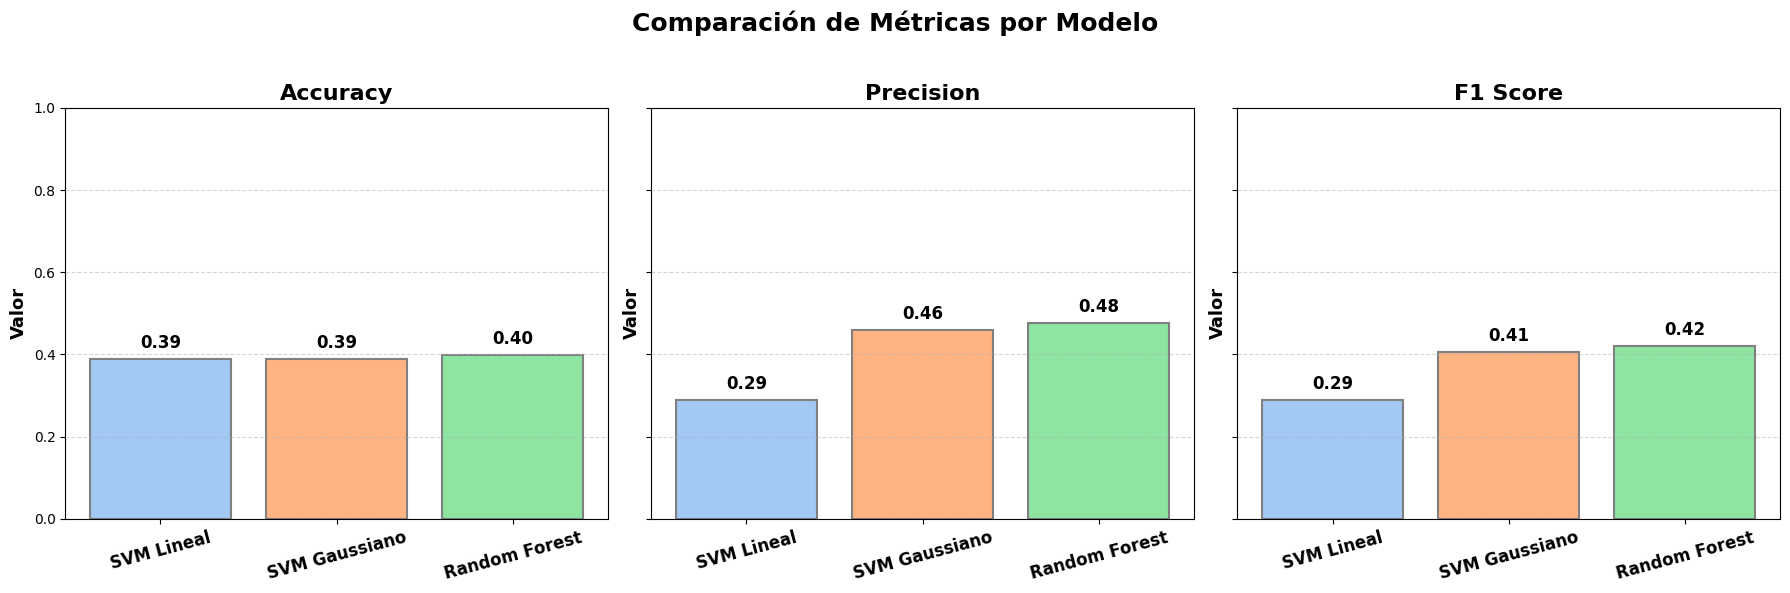

In [59]:
metricas = ['Accuracy', 'Precision', 'F1 Score']
modelos = df_metrics['Modelo']
valores = df_metrics[metricas].values

pastel_palette = sns.color_palette("pastel")

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, metrica in enumerate(metricas[0:]): 
    ax = axes[i]
    bars = ax.bar(modelos, df_metrics[metrica], color=pastel_palette, edgecolor='gray', linewidth=1.5)
    ax.set_title(metrica, fontsize=16, fontweight='bold')
    ax.set_ylabel('Valor', fontsize=13, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.set_xticklabels(modelos, rotation=15, fontsize=12, fontweight='bold')
    # Etiquetas de valor encima de cada barra
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5), textcoords="offset points",
                    ha='center', va='bottom', fontsize=12, fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Título general
fig.suptitle('Comparación de Métricas por Modelo', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Los tres modelos evaluados presentan rendimientos relativamente bajos en todas las métricas consideradas, con un desempeño bastante similar entre el SVM lineal y el SVM con kernel gaussiano.

El Random Forest alcanza valores ligeramente superiores en precisión, recall y F1 Score, aunque la diferencia con los SVM es pequeña y la accuracy general se mantiene baja para todos.

Suponemos que para mejorar el rendimiento, sería necesario considerar ajustes adicionales, mayor ingeniería de características o explorar otras técnicas de modelado.

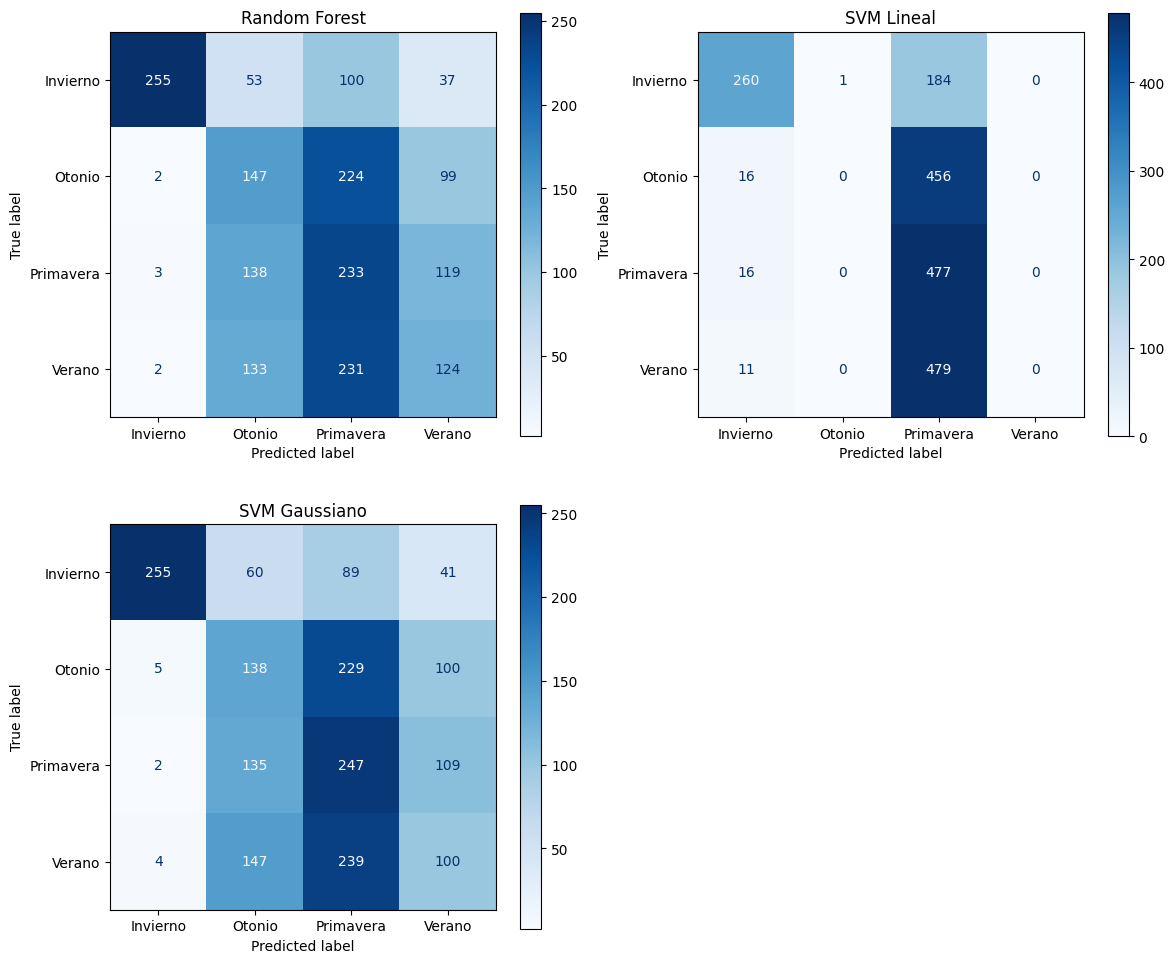

In [60]:
# Lista de etiquetas en el orden correcto según np.unique(y_test)
clases = ['Invierno', 'Otonio', 'Primavera', 'Verano']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Random Forest - posición (0,0)
ConfusionMatrixDisplay.from_estimator(
    best_rf, X_test, y_test,
    display_labels=clases,
    cmap='Blues',
    ax=axes[0, 0],
    xticks_rotation=0
)
axes[0, 0].set_title('Random Forest')

# SVM Lineal - posición (0,1)
ConfusionMatrixDisplay.from_estimator(
    pipeline, X_test, y_test,
    display_labels=clases,
    cmap='Blues',
    ax=axes[0, 1],
    xticks_rotation=0
)
axes[0, 1].set_title('SVM Lineal')

# SVM Gaussiano - posición (1,0) (abajo)
ConfusionMatrixDisplay.from_estimator(
    pipeline_gauss, X_test, y_test,
    display_labels=clases,
    cmap='Blues',
    ax=axes[1, 0],
    xticks_rotation=0
)
axes[1, 0].set_title('SVM Gaussiano')

# Quitamos el subplot vacío (1,1)
fig.delaxes(axes[1,1])

plt.tight_layout()
plt.show()

En las matrices de confusión de los tres modelos se observa que la clase Invierno fue predicha con mayor precisión, mostrando solo algunos errores menores. Esto puede estar vinculado con la relevancia que el modelo Random Forest otorgó a la variable tipoclima con valor “nevado”, facilitando la identificación de esta estación.

Por otro lado, las otras tres estaciones presentan bastante confusión, lo que indica dificultades para distinguirlas correctamente, posiblemente debido a similitudes en las características o a la falta de variables discriminativas adicionales.

Además, se destaca que los modelos SVM Lineal y SVM Gaussiano presentan matrices de confusión idénticas, reflejando un desempeño y patrón de errores muy similar en este caso.